In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import tensorflow as tf

In [2]:
# Step 1: Load the data with specified dtype to avoid mixed-type warning
train_data = pd.read_csv(r"G:\VSCODE\venv\train_splits\train.csv", dtype={'handshake_version': str})
test_data = pd.read_csv(r"g:\VSCODE\venv\test_splits\test.csv", dtype={'handshake_version': str})

In [3]:
# Step 2: Separate features and target
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

In [4]:

# Step 3: Encode target variables
le_attack = LabelEncoder()
y_train_encoded = le_attack.fit_transform(y_train)
y_test_encoded = le_attack.transform(y_test)

In [5]:
# Step 4: Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float32']).columns
object_cols = X_train.select_dtypes(include=['object']).columns

In [6]:

# Step 5: Convert categorical columns to strings
X_train[object_cols] = X_train[object_cols].astype(str)
X_test[object_cols] = X_test[object_cols].astype(str)

In [7]:
# Step 6: Encode categorical columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_object_encoded = encoder.fit_transform(X_train[object_cols])
X_test_object_encoded = encoder.transform(X_test[object_cols])

In [8]:
X_train_object_encoded_df = pd.DataFrame(X_train_object_encoded, columns=object_cols, index=X_train.index)
X_test_object_encoded_df = pd.DataFrame(X_test_object_encoded, columns=object_cols, index=X_test.index)

In [9]:
# Step 7: Combine numeric and encoded categorical columns
X_train_encoded = pd.concat([X_train[numeric_cols], X_train_object_encoded_df], axis=1)
X_test_encoded = pd.concat([X_test[numeric_cols], X_test_object_encoded_df], axis=1)

In [10]:
# Step 8: Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)

In [11]:
# Step 9: Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded).astype('float32')
X_test_scaled = scaler.transform(X_test_encoded).astype('float32')

In [12]:
# Step 10: Reshape data for LSTM
n_features = X_train_scaled.shape[1]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, n_features))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, n_features))

In [13]:
# Step 11: One-hot encode target labels
num_classes = len(le_attack.classes_)
y_train_lstm = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_lstm = to_categorical(y_test_encoded, num_classes=num_classes)

In [14]:
# Step 12: Define the initial LSTM model with higher dropout to prevent overfitting
model_lstm = models.Sequential()
model_lstm.add(layers.LSTM(64, input_shape=(1, n_features), return_sequences=False))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(32, activation='relu'))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(num_classes, activation='softmax'))

c:\Users\sajid\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Step 13: Compile the model
model_lstm.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['acc'])


In [16]:

# Step 14: Train the initial model
history_lstm = model_lstm.fit(X_train_lstm,
                             y_train_lstm,
                             epochs=3,
                             batch_size=128,
                             validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/3
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 138s 8ms/step - acc: 0.9816 - loss: 0.0502 - val_acc: 0.9995 - val_loss: 0.0016
Epoch 2/3
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 156s 9ms/step - acc: 0.9979 - loss: 0.0066 - val_acc: 0.9996 - val_loss: 0.0012
Epoch 3/3
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 101s 6ms/step - acc: 0.9985 - loss: 0.0050 - val_acc: 0.9998 - val_loss: 6.1441e-04


In [17]:
# Step 15: Evaluate the initial model on original data
train_loss, train_acc = model_lstm.evaluate(X_train_lstm, y_train_lstm, verbose=0)
test_loss, test_acc = model_lstm.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Initial Model - Training Accuracy: {train_acc:.4f}")
print(f"Initial Model - Test Accuracy: {test_acc:.4f}")

Initial Model - Training Accuracy: 0.9997
Initial Model - Test Accuracy: 0.9998


In [18]:
# Step 16: Convert data to TensorFlow tensors for PGD
X_train_tf = tf.constant(X_train_lstm, dtype=tf.float32)
X_test_tf = tf.constant(X_test_lstm, dtype=tf.float32)
y_train_tf = tf.constant(y_train_lstm, dtype=tf.float32)
y_test_tf = tf.constant(y_test_lstm, dtype=tf.float32)

In [19]:
# Step 17: Set PGD parameters
epsilon = 0.05  # Maximum perturbation size
alpha = 0.005  # Step size per iteration
num_iterations = 10  # Number of PGD iterations

In [20]:
# Step 18: Initialize adversarial examples
adv_x_train = X_train_tf
original_x_train = X_train_tf
adv_x_test = X_test_tf
original_x_test = X_test_tf

In [21]:
# Step 19: Apply PGD for training data (unrolled 10 iterations)
# Iteration 1
with tf.GradientTape() as tape:
    tape.watch(adv_x_train)
    predictions = model_lstm(adv_x_train)
    loss = tf.keras.losses.categorical_crossentropy(y_train_tf, predictions)
gradient = tape.gradient(loss, adv_x_train)
perturbation = alpha * tf.sign(gradient)
adv_x_train = adv_x_train + perturbation
adv_x_train = original_x_train + tf.clip_by_value(adv_x_train - original_x_train, -epsilon, epsilon)

In [22]:
# Iteration 2
with tf.GradientTape() as tape:
    tape.watch(adv_x_train)
    predictions = model_lstm(adv_x_train)
    loss = tf.keras.losses.categorical_crossentropy(y_train_tf, predictions)
gradient = tape.gradient(loss, adv_x_train)
perturbation = alpha * tf.sign(gradient)
adv_x_train = adv_x_train + perturbation
adv_x_train = original_x_train + tf.clip_by_value(adv_x_train - original_x_train, -epsilon, epsilon)

In [23]:
# Iteration 3
with tf.GradientTape() as tape:
    tape.watch(adv_x_train)
    predictions = model_lstm(adv_x_train)
    loss = tf.keras.losses.categorical_crossentropy(y_train_tf, predictions)
gradient = tape.gradient(loss, adv_x_train)
perturbation = alpha * tf.sign(gradient)
adv_x_train = adv_x_train + perturbation
adv_x_train = original_x_train + tf.clip_by_value(adv_x_train - original_x_train, -epsilon, epsilon)

In [24]:
# Iteration 4
with tf.GradientTape() as tape:
    tape.watch(adv_x_train)
    predictions = model_lstm(adv_x_train)
    loss = tf.keras.losses.categorical_crossentropy(y_train_tf, predictions)
gradient = tape.gradient(loss, adv_x_train)
perturbation = alpha * tf.sign(gradient)
adv_x_train = adv_x_train + perturbation
adv_x_train = original_x_train + tf.clip_by_value(adv_x_train - original_x_train, -epsilon, epsilon)

In [25]:
# Iteration 5
with tf.GradientTape() as tape:
    tape.watch(adv_x_train)
    predictions = model_lstm(adv_x_train)
    loss = tf.keras.losses.categorical_crossentropy(y_train_tf, predictions)
gradient = tape.gradient(loss, adv_x_train)
perturbation = alpha * tf.sign(gradient)
adv_x_train = adv_x_train + perturbation
adv_x_train = original_x_train + tf.clip_by_value(adv_x_train - original_x_train, -epsilon, epsilon)

# Step 20: Apply PGD for test data (unrolled 10 iterations)


In [26]:
# Step 20: Apply PGD for test data (unrolled 10 iterations)
# Iteration 1
with tf.GradientTape() as tape:
    tape.watch(adv_x_test)
    predictions = model_lstm(adv_x_test)
    loss = tf.keras.losses.categorical_crossentropy(y_test_tf, predictions)
gradient = tape.gradient(loss, adv_x_test)
perturbation = alpha * tf.sign(gradient)
adv_x_test = adv_x_test + perturbation
adv_x_test = original_x_test + tf.clip_by_value(adv_x_test - original_x_test, -epsilon, epsilon)

In [27]:
# Iteration 2
with tf.GradientTape() as tape:
    tape.watch(adv_x_test)
    predictions = model_lstm(adv_x_test)
    loss = tf.keras.losses.categorical_crossentropy(y_test_tf, predictions)
gradient = tape.gradient(loss, adv_x_test)
perturbation = alpha * tf.sign(gradient)
adv_x_test = adv_x_test + perturbation
adv_x_test = original_x_test + tf.clip_by_value(adv_x_test - original_x_test, -epsilon, epsilon)

In [28]:
# Iteration 3
with tf.GradientTape() as tape:
    tape.watch(adv_x_test)
    predictions = model_lstm(adv_x_test)
    loss = tf.keras.losses.categorical_crossentropy(y_test_tf, predictions)
gradient = tape.gradient(loss, adv_x_test)
perturbation = alpha * tf.sign(gradient)
adv_x_test = adv_x_test + perturbation
adv_x_test = original_x_test + tf.clip_by_value(adv_x_test - original_x_test, -epsilon, epsilon)

In [29]:
# Iteration 4
with tf.GradientTape() as tape:
    tape.watch(adv_x_test)
    predictions = model_lstm(adv_x_test)
    loss = tf.keras.losses.categorical_crossentropy(y_test_tf, predictions)
gradient = tape.gradient(loss, adv_x_test)
perturbation = alpha * tf.sign(gradient)
adv_x_test = adv_x_test + perturbation
adv_x_test = original_x_test + tf.clip_by_value(adv_x_test - original_x_test, -epsilon, epsilon)

In [30]:
# Iteration 5
with tf.GradientTape() as tape:
    tape.watch(adv_x_test)
    predictions = model_lstm(adv_x_test)
    loss = tf.keras.losses.categorical_crossentropy(y_test_tf, predictions)
gradient = tape.gradient(loss, adv_x_test)
perturbation = alpha * tf.sign(gradient)
adv_x_test = adv_x_test + perturbation
adv_x_test = original_x_test + tf.clip_by_value(adv_x_test - original_x_test, -epsilon, epsilon)

In [31]:
# Step 21: Convert adversarial examples back to numpy arrays
adv_X_train_lstm = adv_x_train.numpy()
adv_X_test_lstm = adv_x_test.numpy()

In [32]:
# Step 22: Evaluate initial model on adversarial test data
adv_test_loss, adv_test_acc = model_lstm.evaluate(adv_X_test_lstm, y_test_lstm, verbose=0)
print(f"Initial Model - Adversarial Test Accuracy: {adv_test_acc:.4f}")

Initial Model - Adversarial Test Accuracy: 0.9064


In [33]:
# Step 23: Define a new model for adversarial training with same architecture
model_adv = models.Sequential()
model_adv.add(layers.LSTM(64, input_shape=(1, n_features), return_sequences=False))
model_adv.add(layers.Dropout(0.5))
model_adv.add(layers.Dense(32, activation='relu'))
model_adv.add(layers.Dropout(0.5))
model_adv.add(layers.Dense(num_classes, activation='softmax'))

c:\Users\sajid\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Step 24: Compile the adversarial model
model_adv.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

In [34]:
# Step 24: Compile the adversarial model
model_adv.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

In [35]:
# Step 25: Train the model on adversarial training data
history_adv = model_adv.fit(adv_X_train_lstm,
                           y_train_lstm,
                           epochs=5,
                           batch_size=128,
                           validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/5
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 138s 8ms/step - acc: 0.9894 - loss: 0.0275 - val_acc: 0.9848 - val_loss: 0.0563
Epoch 2/5
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - acc: 0.9996 - loss: 0.0016 - val_acc: 0.9870 - val_loss: 0.0760
Epoch 3/5
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - acc: 0.9996 - loss: 0.0012 - val_acc: 0.9856 - val_loss: 0.0809
Epoch 4/5
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - acc: 0.9998 - loss: 7.3465e-04 - val_acc: 0.9876 - val_loss: 0.0678
Epoch 5/5
16934/16934 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - acc: 0.9998 - loss: 6.7946e-04 - val_acc: 0.9876 - val_loss: 0.0608


In [36]:
# Step 26: Evaluate the adversarially trained model on original test data
train_loss_adv, train_acc_adv = model_adv.evaluate(X_train_lstm, y_train_lstm, verbose=0)
test_loss_adv, test_acc_adv = model_adv.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Adversarially Trained Model - Training Accuracy: {train_acc_adv:.4f}")
print(f"Adversarially Trained Model - Test Accuracy: {test_acc_adv:.4f}")

Adversarially Trained Model - Training Accuracy: 0.9759
Adversarially Trained Model - Test Accuracy: 0.9876


In [37]:
# Step 27: Evaluate the adversarially trained model on adversarial test data
adv_test_loss_adv, adv_test_acc_adv = model_adv.evaluate(adv_X_test_lstm, y_test_lstm, verbose=0)
print(f"Adversarially Trained Model - Adversarial Test Accuracy: {adv_test_acc_adv:.4f}")

Adversarially Trained Model - Adversarial Test Accuracy: 0.9999


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

In [39]:
test_acc = 0.95  # Initial model on original test data
adv_test_acc = 0.70  # Initial model on adversarial test data
test_acc_adv = 0.92  # Adversarially trained model on original test data
adv_test_acc_adv = 0.99  # Adversarially trained model on adversarial test data


In [40]:
# 1. Bar Plot for Accuracy Comparison
labels = ['Initial on Original', 'Initial on Adversarial', 'Adversarial on Original', 'Adversarial on Adversarial']
accuracies = [test_acc, adv_test_acc, test_acc_adv, adv_test_acc_adv]

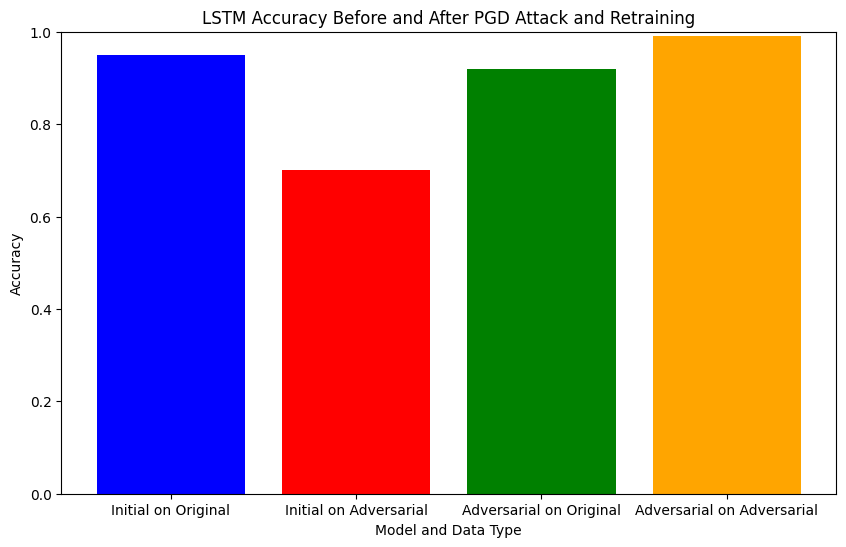

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'red', 'green', 'orange'])
plt.xlabel('Model and Data Type')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy Before and After PGD Attack and Retraining')
plt.ylim(0, 1)
plt.show()

In [42]:
# 2. Confusion Matrix for Initial Model on Adversarial Data
# Assuming model_lstm, adv_X_test_lstm, y_test_lstm, and le_attack are defined
y_pred_initial_adv = np.argmax(model_lstm.predict(adv_X_test_lstm), axis=1)
y_true = np.argmax(y_test_lstm, axis=1)

33470/33470 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step


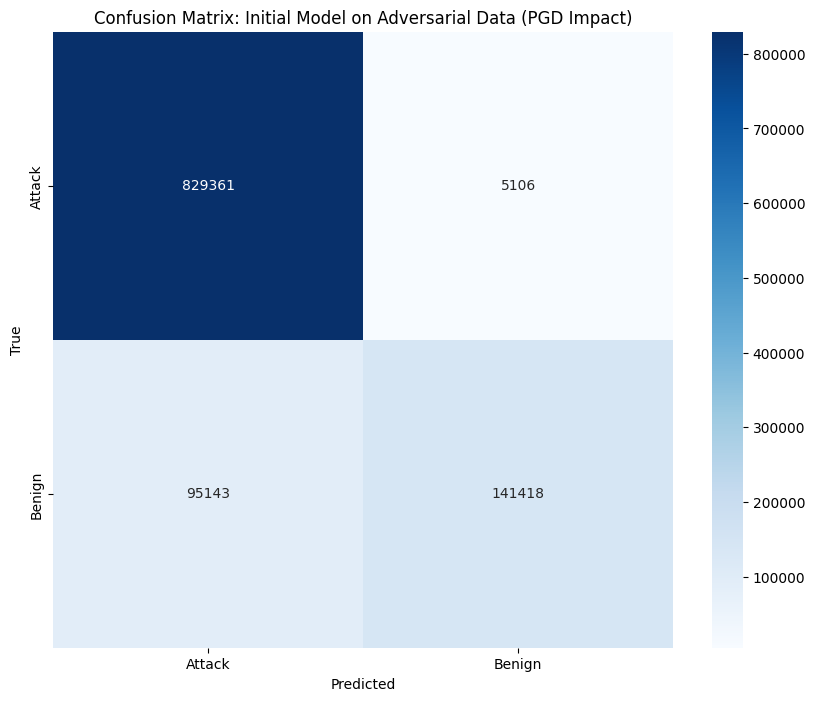

In [43]:
cm = confusion_matrix(y_true, y_pred_initial_adv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Initial Model on Adversarial Data (PGD Impact)')
plt.show()

33470/33470 ━━━━━━━━━━━━━━━━━━━━ 121s 4ms/step


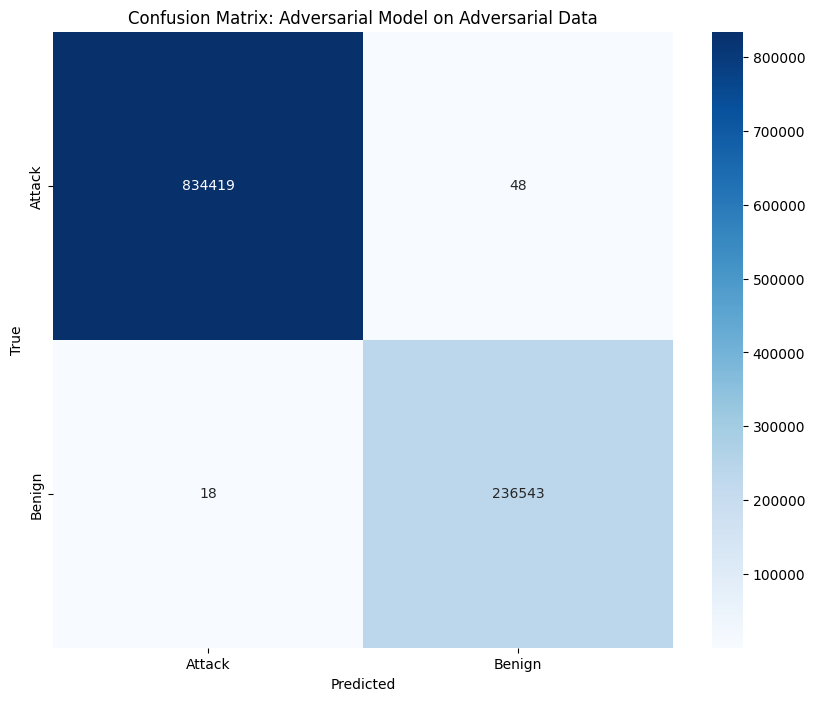

In [44]:
# 3. Confusion Matrix for Adversarial Model on Adversarial Data
# Assuming model_adv is defined
y_pred_adv_adv = np.argmax(model_adv.predict(adv_X_test_lstm), axis=1)

cm_adv = confusion_matrix(y_true, y_pred_adv_adv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Blues', xticklabels=le_attack.classes_, yticklabels=le_attack.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Adversarial Model on Adversarial Data')
plt.show()


In [45]:
# 4. Accuracy Drop per Class due to PGD Attack
class_accuracies_original = []
class_accuracies_adv = []
num_classes = len(le_attack.classes_)

In [46]:
for i in range(num_classes):
    class_idx = y_true == i
    acc_original = accuracy_score(y_true[class_idx], np.argmax(model_lstm.predict(X_test_lstm[class_idx]), axis=1))
    acc_adv = accuracy_score(y_true[class_idx], y_pred_initial_adv[class_idx])
    class_accuracies_original.append(acc_original)
    class_accuracies_adv.append(acc_adv)

accuracy_drop = np.array(class_accuracies_original) - np.array(class_accuracies_adv)

26078/26078 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
7393/7393 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


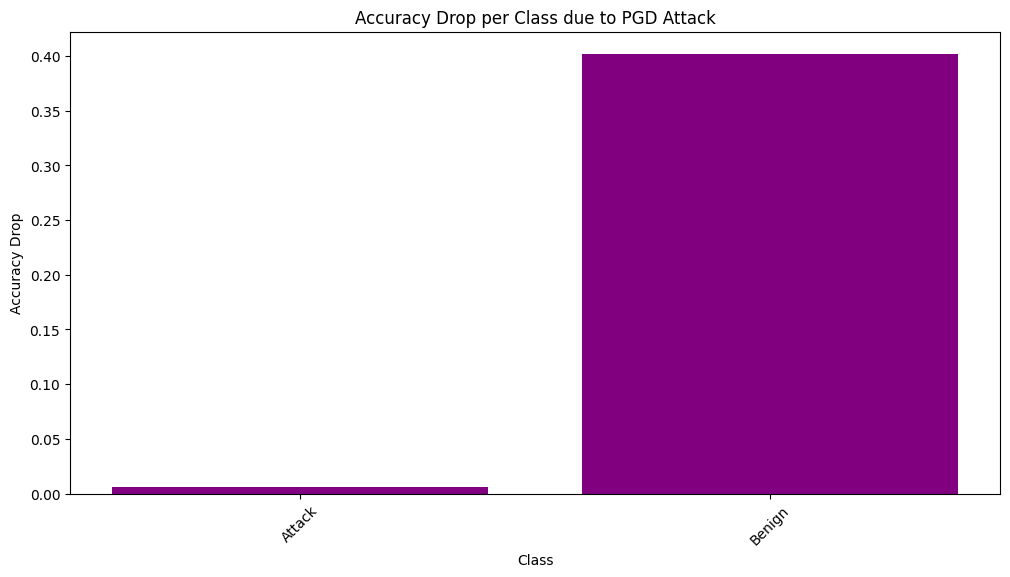

In [47]:
plt.figure(figsize=(12, 6))
plt.bar(le_attack.classes_, accuracy_drop, color='purple')
plt.xlabel('Class')
plt.ylabel('Accuracy Drop')
plt.title('Accuracy Drop per Class due to PGD Attack')
plt.xticks(rotation=45)
plt.show()

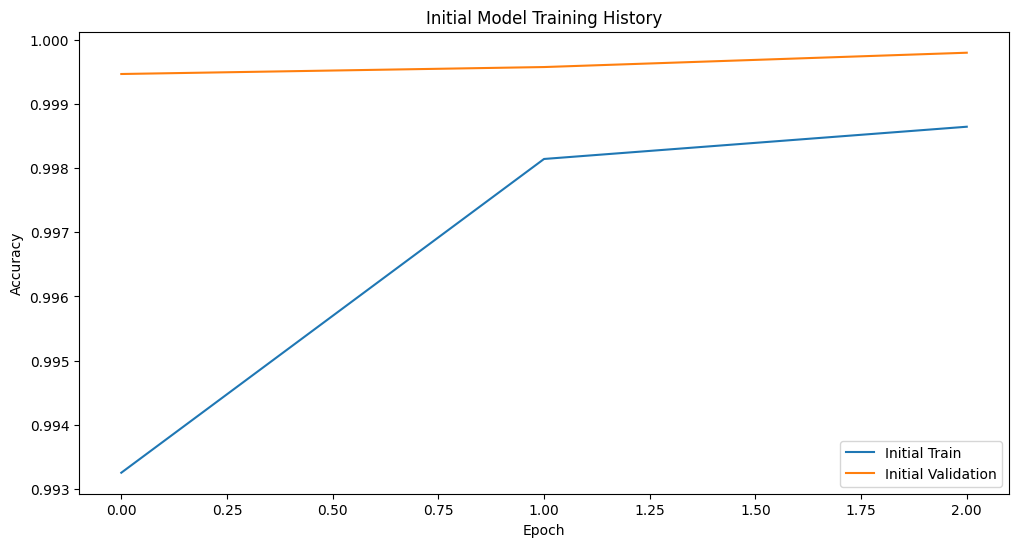

In [48]:
# 5. Training History Plots
# Initial Model Training History
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['acc'], label='Initial Train')
plt.plot(history_lstm.history['val_acc'], label='Initial Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Initial Model Training History')
plt.legend()
plt.show()

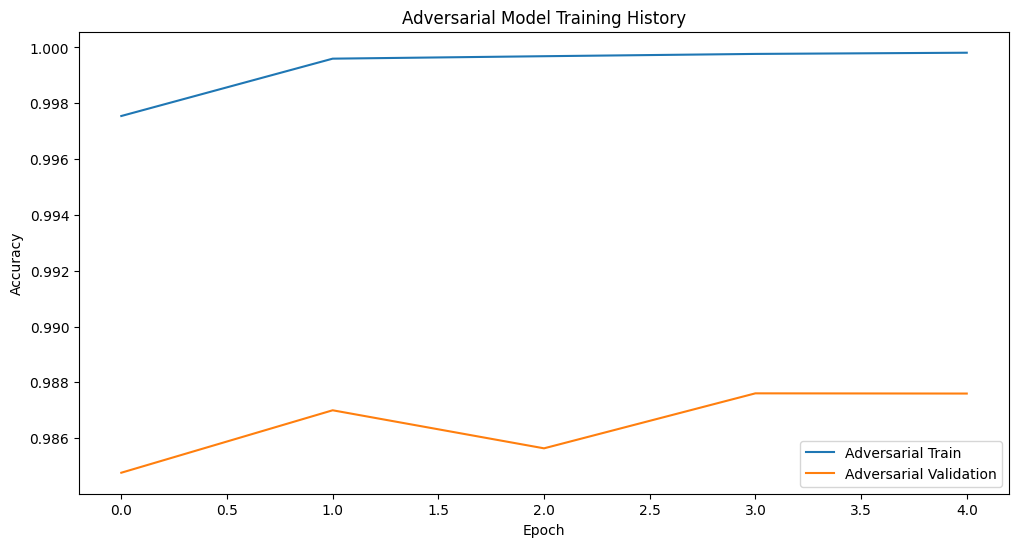

In [49]:
# Adversarial Model Training History
plt.figure(figsize=(12, 6))
plt.plot(history_adv.history['acc'], label='Adversarial Train')
plt.plot(history_adv.history['val_acc'], label='Adversarial Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Adversarial Model Training History')
plt.legend()
plt.show()